# Libs

In [1]:
import PIL
import PIL.Image as Image
import cv2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import numpy as np
import matplotlib.pyplot as plt

2023-04-19 12:31:27.868378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_img(path):
    img = PIL.Image.open(path)
    img = img.resize((32, 32))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return tf.convert_to_tensor(img_array)

In [12]:
content_img = get_img('input_image/dancing.jpg')
content_img = tf.reshape(content_img, [1,32,32,3])
style_img = get_img('input_image/saryan.jpg')
style_img = tf.reshape(style_img, [1,32,32,3])
target_img = 0.5*(content_img+style_img)

In [13]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False
)

vgg_layers = []
vgg_layers.append(base_model.layers[0])
for layer in base_model.layers:
    if "conv" in layer.name:
        layer.trainable = False
        vgg_layers.append(layer)

In [14]:
def VGG_Net(layers):
    
    model = keras.models.Sequential()
    for layer in layers[:6]:
        layer.trainable = True
        model.add(layer)
    
    return model

In [15]:
model = VGG_Net(vgg_layers)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block2_conv1 (Conv2D)       multiple                  73856     
                                                                 
 block2_conv2 (Conv2D)       multiple                  147584    
                                                                 
 block3_conv1 (Conv2D)       multiple                  295168    
                                                                 
Total params: 555,328
Trainable params: 555,328
Non-trainable params: 0
_________________________________________________________________


In [16]:
vgg_c = VGG_Net(vgg_layers)
vgg_s = VGG_Net(vgg_layers)
vgg_t = VGG_Net(vgg_layers)

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
b_loss = keras.losses.BinaryCrossentropy()

In [18]:
vgg_t.compile(loss=b_loss, optimizer=optimizer)

In [19]:
epochs = 100

target0 = vgg_t(target_img)

loss_collection= []
for epoch in range(epochs):

    target = vgg_t(target_img)

    loss, loss_c, loss_s = 0, 0, 0

    cont_l = content_img
    style_l = style_img
    target_l = target_img

    with tf.GradientTape() as g_tape:
        for n,layer in enumerate(vgg_t.layers):

            cont_l = vgg_c.layers[n](cont_l)
            target_l = vgg_t.layers[n](target_l)

            loss_c += tf.norm(cont_l-target_l)
            
            style_l = vgg_s.layers[n](style_l)
            _, c, h, w = style_l.shape
            style_l_t = style_l.reshape(c, h * w)
            target_l_t = target_l.reshape(c, h * w)
            
            loss_s += tf.norm(style_l_t-target_l_t)

    loss = loss_c
    grad = g_tape.gradient(loss, vgg_t.trainable_variables)
    optimizer.apply_gradients(zip(grad, vgg_t.trainable_variables))
    loss_collection.append(loss)

target1 = vgg_t(target_img)
print(tf.norm(target1-target0))

tf.Tensor(2789.4207, shape=(), dtype=float32)


Text(0, 0.5, 'Loss')

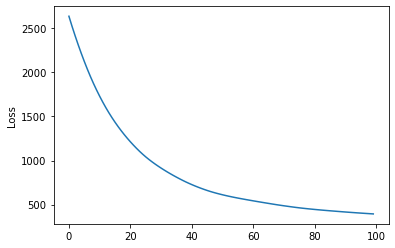

In [20]:
plt.plot(loss_collection)
plt.ylabel("Loss")